# Prior entropy of the hidden states

In [3]:
import os
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sys.path.append('../..')
from plot_params import*
from helper import*
pp = PlotParams()
import random
from paths import*
paths = paths()

### To do: 
- read all the csv-s and merge them
- calculate the entropy for each participant
- plot the results

In [4]:
path = paths.f4_python_analysis + 'prior_entropies/'
entropy_csvs = os.listdir(path)

In [5]:
 entropy_csvs = [item for item in entropy_csvs if item[0]!= '.']

In [6]:
csv_dfs = [pd.read_csv(path + csv, index_col = [0]) for csv in entropy_csvs]
entropy_data = pd.concat(csv_dfs)
entropy_data.reset_index(inplace=True, drop = True)
entropy_data.drop('Pi_matrices', axis = 1, inplace=True)

/var/folders/j5/sdcqcn450vj04kd1_kb4xv6c0000gn/T/ipykernel_30377/2055288155.py:2: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  entropy_data = pd.concat(csv_dfs)


In [7]:
def convert_to_list(x):
    entropy_list = [float(item) for item in x.replace('[', '').replace(']', '').split(',')]
    return entropy_list

In [8]:
df = copy.deepcopy(entropy_data)
df['entropies_int'] = df.entropies.apply(convert_to_list)
df['entropy_mean'] = df.entropies_int.apply(np.mean)
df['entropy_std'] = df.entropies_int.apply(np.std)
df.drop('entropies', axis = 1, inplace=True)
df.drop('entropies_int', axis = 1, inplace=True)

## Sanity check: check the std across chains

In [9]:
# df_by_chains = copy.deepcopy(df)
# df_by_chains.set_index(['chain', 'participant', "blocks"], inplace=True)
# df_by_chains = df_by_chains.unstack(0)
# participants = sorted(list(set([item[0] for item in df_by_chains.index])))

In [10]:
# df_by_chains['std_in_entropy_mean'] = df_by_chains['entropy_mean'].std(axis = 1)
# df_by_chains.sort_values('std_in_entropy_mean')

## Plot the prior entropy

In [11]:
df.drop('chain', axis = 1, inplace=True)
df = df.groupby(['participant', 'blocks']).mean()
df_to_boxplot = copy.deepcopy(df)
df = df.unstack(1)
df_to_plot = df['entropy_mean']
df_to_plot.reset_index(inplace=True)

In [12]:
def get_x_jitter(df, columns, jitter = 0.05):

    
    '''
    Columns expected to be a list. 
    
    '''
    
    random.seed(10) 
    x_jitter = pd.DataFrame(np.random.normal(loc=0,
                                             scale=jitter, 
                                             size=df.values.shape),
                                             columns=df.columns)
    # ennek a sornak az a lényege, hogy növekvő értékűvé tegye a random noise data-t. 
    # Tehát az első oszlophoz 0-t, a másidikhoz 1-et adok hozzá hozzá. 

    x_jitter[columns] += np.arange(len(columns))
    return (x_jitter[columns])

In [13]:
x_jitter = get_x_jitter(df_to_plot, df_to_plot.columns[1:])

### JITTER PLOT

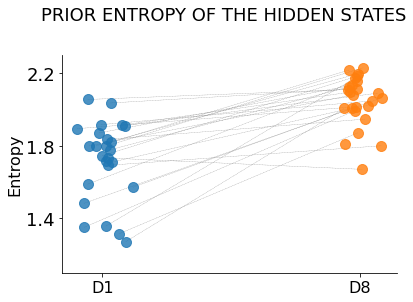

In [14]:
fig, ax = plt.subplots(1, 1, facecolor = 'white')


for col in df_to_plot.columns[1:]:

        
        ax.plot(x_jitter.loc[:, col], df_to_plot.loc[:, col], 'o', ms = 10, zorder=1, alpha = 0.8)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['D1', 'D8'], fontsize = 16)
#         ax.set_xlim(-0.5,1.5)
        ax.set_ylim(1.1, 2.3)
        ax.set_yticks([1.4, 1.8, 2.2])
        ax.set_yticklabels([1.4, 1.8, 2.2], fontsize = 18)
        ax.set_ylabel('Entropy', fontsize = 16)


for idx in df_to_plot.index[1:]:
    ax.plot(x_jitter.loc[idx, df_to_plot.columns[1:]],
            df_to_plot.loc[idx, df_to_plot.columns[1:]],
            color = 'grey', 
            linewidth = 0.3, linestyle = '--', zorder=-1)




plt.suptitle("PRIOR ENTROPY OF THE HIDDEN STATES", fontsize = 18, y = 1.05)
sns.despine()
plt.savefig(paths.plot_save_path +'hidden_states/' + 'prior_state_entropy_scatter.png', bbox_inches='tight');

# Jitter + Violin

In [15]:
def get_significance_notation(axhline_y = 2.4, axhline_xmin = 0.25, axhline_xmax = .75, 
                              axvline_ymax = 2.4, axvline_ymin = 2.2,
                              text_x = 0.5, text_y = 2.45, fontsize = 18): 

    sns_plot.axhline(y = axhline_y, xmin = 0.25, xmax = .75, color = 'black', lw = 0.8)
    sns_plot.axvline(x = 0, ymax = axvline_ymax, ymin =axvline_ymin, color = 'black', lw = 0.8)
    sns_plot.axvline(x = 1, ymax = axvline_ymax, ymin =axvline_ymin, color = 'black', lw = 0.8)
    sns_plot.text(text_x, text_y, '***', fontsize = fontsize)

In [16]:
#x_jitter = get_x_jitter(df_to_plot, df_to_plot.columns[1:])

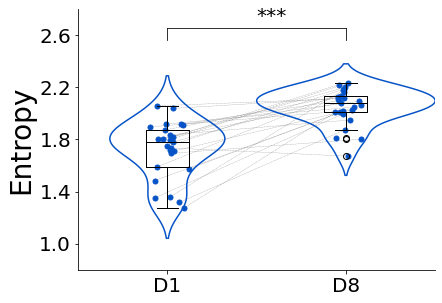

In [21]:
fig, ax = plt.subplots(1, 1, figsize = pp.figsize, facecolor = 'white')

light_blue = '#4dc4ff'
################################
### SNS violinplot
################################
sns_plot = sns.violinplot(data = df_to_boxplot, x = 'blocks', y = 'entropy_mean',
                          alpha = 1, fill = False, 
                          width = 1,
                          color = pp.basic_color, inner = None)


sns_plot = sns.boxplot(data = df_to_boxplot, x = 'blocks', y = 'entropy_mean', saturation=1, 
                       width=0.24, boxprops={'zorder': 2},
                       fill = None,
                       linewidth=1,
                      # whis = [0, 100],
                       color = 'black')


################################
### Jitter
################################
for col in df_to_plot.columns[1:]:

        
        ax.plot(x_jitter.loc[:, col], df_to_plot.loc[:, col], 'o', ms = 5, zorder=1, color = pp.basic_color)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['D1', 'D8'], fontsize = pp.ticklabsize)
        ax.set_xlim(-0.5, 1.5)
        ax.set_ylim(0.8, 2.8)
        ax.set_yticks(np.arange(1, 2.8, 0.4))
        ax.set_yticklabels(np.round(np.arange(1, 2.8, 0.4), decimals = 1), fontsize = pp.ticklabsize)
        ax.set_ylabel('Entropy', fontsize = pp.axlabsize)
        ax.set_xlabel(None)


for idx in df_to_plot.index[1:]:
    ax.plot(x_jitter.loc[idx, df_to_plot.columns[1:]],
            df_to_plot.loc[idx, df_to_plot.columns[1:]],
            color = 'grey', 
            linewidth = 0.3, linestyle = '--', zorder=-1)


get_significance_notation(axhline_y = 2.65, axhline_xmin = 0.25, axhline_xmax = .75,
                          axvline_ymax = 0.925, axvline_ymin = 0.88,
                          text_x = 0.5, text_y = 2.7, fontsize = 20)

# sns_plot.axvline(x = 0, ymax = 0.92, ymin =0.88, color = 'black', lw = 0.8)
# sns_plot.axvline(x = 1, ymax = 3, ymin =0, color = 'black', lw = 0.8)

#plt.suptitle("PRIOR ENTROPY OF THE HIDDEN STATES", fontsize = 18, y = 1.05)
sns.despine()
plt.savefig(paths.plot_save_path +'hidden_states/' + 'prior_state_entropy_violin+jitter.png', bbox_inches='tight');

## Paired t-test

In [22]:
results = stats.ttest_rel(df_to_plot['11_20'], df_to_plot['186_195'])
print('t-value:', np.round(results.statistic, decimals = 3),
      'p-value:', np.round(results.pvalue, decimals = 3),
      'df:', results.df)

t-value: -7.058 p-value: 0.0 df: 24
